# Service Calls and Correlation

In the last 0.6 notebook, there was not a strong correlation between service calls for actual fires, and the temperature.

In this next analysis, we'll do a similar analysis, but we'll look at ALL service calls, including false alarms, and medical emergencies. Attempt to programmatically access the NOAA dataset.


### TODO List

This notebook is querying the "Fire Incidents" dataset:

> Fire Incidents includes a summary of each (non-medical) incident to which the SF Fire Department responded. Each incident record includes the call number, incident number, address, number and type of each unit responding, call type (as determined by dispatch), prime situation (field observation), actions taken, and property loss.

In [237]:
from __future__ import division, print_function
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Fetching Fire Data

First we will fetch the firedata, themost recent 100,000 rows of data. We will also clean it by dropping columns, and converting date-related columns to datetime objects.

IMPORTANT TO NOTE: That resource identifier, and the link used is described as follows:

>Fire Incidents includes a summary of each (non-medical) incident to which the SF Fire Department responded. Each incident record includes the call number, incident number, address, number and type of each unit responding, call type (as determined by dispatch), prime situation (field observation), actions taken, and property loss.

That means that the data is only including non-medical calls to the fire department. If we want to look at ALL calls to the Fire Department, that's a different data set.

In [238]:
query_url = 'https://data.sfgov.org/resource/wbb6-uh78.json?$order=close_dttm%20DESC&$offset={}&$limit={}'
offset = 0
limit = 100000
fdf = pd.read_json(query_url.format(offset, limit))

In [239]:
def clean_fire_data(df):
    cols_to_drop = ["automatic_extinguishing_sytem_failure_reason",
                "automatic_extinguishing_sytem_type",
                "battalion",
                "box",
                "call_number",
                "detector_effectiveness",
                "detector_failure_reason",
                "ems_personnel",
                "ems_units",
                "exposure_number",
                "first_unit_on_scene",
                "ignition_factor_secondary",
                "mutual_aid",
                "no_flame_spead",
                "other_personnel",
                "other_units",
                "station_area",
                "supervisor_district"]
    df = df.drop(cols_to_drop, axis=1)
    for col in df.columns:
        if 'dttm' in col:
            df[col] = pd.to_datetime(df[col])
    return df

In [240]:
fdf = clean_fire_data(fdf)

In [241]:
print(fdf.alarm_dttm.min())
print(fdf.alarm_dttm.max())


2013-02-22 19:08:56
2016-07-23 21:48:51


In [242]:
# we'll do the same thing with the weather csv, do a little exploration on it too
tdf = pd.read_table('../../data/external/noaa/5991787088242dat.txt', delim_whitespace=True)


In [243]:
# for col in tdf.columns:
#     print(col)

In [244]:
def clean_noaa_download(df):
    # we need to fix the YR--MODAHRMN column

    # The building ferry data sucks. I'll look at the SF Airport dataa
#     df = df[df.USAF == 998479]  # only getting the ferry building data   

    df = df[df.USAF == 724940]  # SFO data
    
    mask = df['TEMP'] == '****'
    df.loc[mask, 'TEMP'] = np.nan
     
    df.TEMP = pd.to_numeric(df.TEMP, errors='coerce')
    df.DIR = pd.to_numeric(df.DIR, errors='coerce')
    df.loc[df.SLP == '******', 'SLP'] = np.nan
    df.SLP = pd.to_numeric(df.SLP, errors='coerce')
#     df.PCP24 = pd.to_numeric(df.PCP24, errors='coerce')
#     df.DEWP = pd.to_numeric(df.DEWP, errors='coerce')
    
    # YR--MODAHRMN = YEAR-MONTH-DAY-HOUR-MINUTE IN GREENWICH MEAN TIME (GMT)
    df['dttm'] = pd.to_datetime(df['YR--MODAHRMN'], format='%Y%m%d%H%M')
    cols_to_keep = [#'USAF', 
#                     "WBAN",
#                     "YR--MODAHRMN",
#                     "DIR",
#                     "SPD",
#                     "GUS",
#                     "CLG",
#                     "SKC",
#                     "L",
#                     "M",
#                     "H",
#                     "VSB",
#                     "MW",
#                     "MW.1",
#                     "MW.2",
#                     "MW.3",
#                     "AW",
#                     "AW.1",
#                     "AW.2",
#                     "AW.3",
#                     "W",
                    "TEMP",
#                     "DEWP",
#                     "SLP",
#                     "ALT",
#                     "STP",
#                     "MAX",
#                     "MIN",
#                     "PCP01",
#                     "PCP06",
#                     "PCP24",
#                     "PCPXX",
#                     "SD",
                    'dttm']
    df = df[cols_to_keep]
    return df

In [245]:
tdf = clean_noaa_download(tdf)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [246]:
tdf.describe()

,TEMP
count,39236.000000
mean,58.915435
std,7.105485
min,35.000000
25%,54.000000
50%,58.000000
75%,63.000000
max,93.000000


In [247]:
tdf.shape

(40505, 2)

In [248]:
tdf.head()

,TEMP,dttm
0,62,2013-02-01 00:00:00
1,58,2013-02-01 00:56:00
2,56,2013-02-01 01:56:00
3,54,2013-02-01 02:56:00
4,53,2013-02-01 03:56:00


In [249]:
# tdf.DEWP.value_counts(dropna=False)

In [250]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40505 entries, 0 to 40504
Data columns (total 2 columns):
TEMP    39236 non-null float64
dttm    40505 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 949.3 KB


In [251]:
# sns.pairplot?

In [252]:
# with open('../../config.json', 'r') as fh:
#     weather_api_key = json.load(fh)['ncdc']['token']

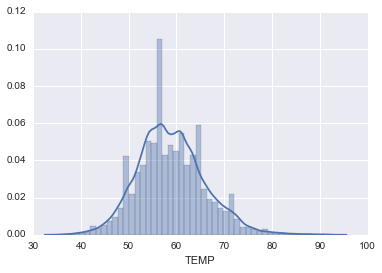

In [253]:
sns.distplot(tdf[tdf.TEMP.notnull()].TEMP);

In [254]:
tdf.head()

,TEMP,dttm
0,62,2013-02-01 00:00:00
1,58,2013-02-01 00:56:00
2,56,2013-02-01 01:56:00
3,54,2013-02-01 02:56:00
4,53,2013-02-01 03:56:00


In [255]:
tdf = tdf.set_index('dttm')

#### Grouping

Now that we have the fire data in `fdf` and the weather data in `tdf` we will do some grouping.

The name of our group `gdf` will group our data from `fdf` in hourly counts.


In [256]:
gdf = fdf.rename(columns={'alarm_dttm':'dttm'}).set_index('dttm').groupby(pd.TimeGrouper('H')).count()['incident_number']

In [257]:
gdf.head()

dttm
2013-02-22 19:00:00    2
2013-02-22 20:00:00    5
2013-02-22 21:00:00    4
2013-02-22 22:00:00    5
2013-02-22 23:00:00    4
Freq: H, Name: incident_number, dtype: int64

In [258]:
gdf.tail()

dttm
2016-07-23 17:00:00    1
2016-07-23 18:00:00    1
2016-07-23 19:00:00    2
2016-07-23 20:00:00    1
2016-07-23 21:00:00    2
Freq: H, Name: incident_number, dtype: int64

In [259]:
gdf.describe()

count    29931.000000
mean         3.341018
std          2.325186
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         58.000000
Name: incident_number, dtype: float64

In [260]:
tdf.head()

,TEMP
dttm,
2013-02-01 00:00:00,62
2013-02-01 00:56:00,58
2013-02-01 01:56:00,56
2013-02-01 02:56:00,54
2013-02-01 03:56:00,53


In [261]:
tdf.shape

(40505, 1)

In [262]:
ndf = gdf.reset_index().merge(tdf.reset_index(), on='dttm')

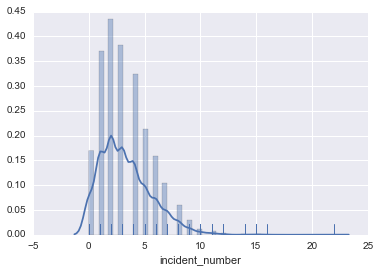

In [263]:
sns.distplot(ndf.incident_number, hist=True, rug=True);

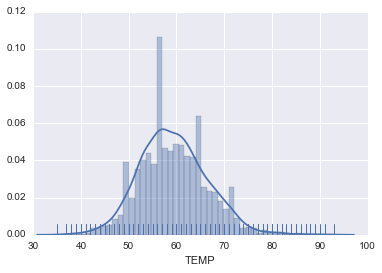

In [264]:
sns.distplot(ndf.TEMP, hist=True, rug=True);

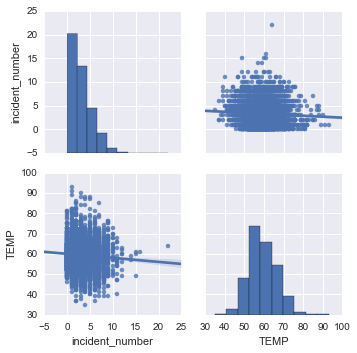

In [265]:
# sns.jointplot(x="TEMP", y="incident_count", data=ndf, kind='reg');
sns.pairplot(ndf, kind='reg')

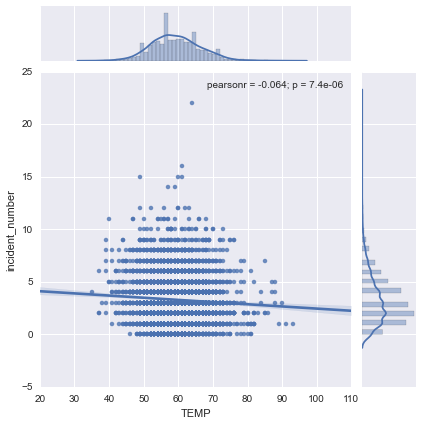

In [266]:
sns.jointplot(x='TEMP', y='incident_number', data=ndf, kind='reg')

In [267]:
ndf.corr()

,incident_number,TEMP
incident_number,1.000000,-0.064038
TEMP,-0.064038,1.000000


### No Correlation

There is clearly not a strong correlation between the number of incidents in a given hour, and the temperature of that hour. **We cannot as of yet reject the null hypothesis, which is that there is no significant correlation between temperature and fire department calls for service.**

We can, however, change the experiment, and see if the change in temperature earlier in the day will impact the number of alarms, and the type of alarms, that occur later on in the day.

One thing I do find interesting is that outlier in the previous chart. 

In [268]:
ndf.describe()

,incident_number,TEMP
count,4892.000000,4892.000000
mean,3.283729,59.358545
std,2.293804,7.098212
min,0.000000,35.000000
25%,2.000000,54.000000
50%,3.000000,59.000000
75%,5.000000,64.000000
max,22.000000,93.000000


When I get the descriptive analytics, I see that the average number of calls in a single hour are 3.2 and yet the max is 22 (it's in the table above, under 'max' of 'incident_number'). That's a big enough difference to be interesting!

We will come back to the general value of outliers, but first let's do some broader exploration of our dataset, to visualy see what patterns are unusual.

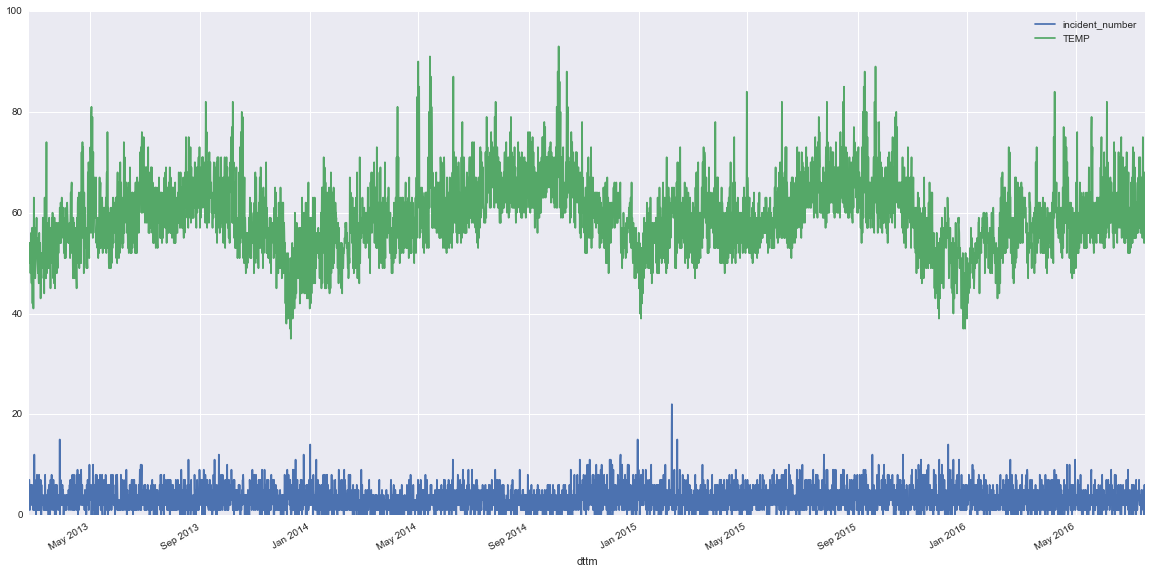

In [269]:
ndf[['incident_number','TEMP','dttm']].set_index('dttm').plot(figsize=(20,10), kind='line')

In [292]:
ndf[ndf.incident_number == ndf.incident_number.describe()['max']]

,dttm,incident_number,TEMP,month,year
2806,2015-02-06 18:00:00,22,64,2,2015


The above chart is pretty straightforward. When we created `ndf` it was simply a record of the weather records we had for each hour for San Francisco, and then we overlayed the total count of incidents for that hour, meaning number of calls the fire department. I find it interesting that there are no meaningful patterns in the seasonality of the data, the way we see with the temperature, but that could simply be that we need to zoom out more, and do groupings and averages by week or month.

You can see that in this view, which is hourly, we see a big spike on February 06 2015. The temperature was at the 75% percentile at 64 degrees, but the incident number jumped to 22 within a single hour, compared to the mean of 3.2 and the median of 3.0 incidents per hour. Let's dig into this outlier for a moment, and also check news to find out why.

In [295]:
mintime = pd.tslib.Timestamp("Feb 06 2015")
maxtime = pd.tslib.Timestamp("Feb 07 2015")
mask = ((fdf.alarm_dttm >= mintime) & (fdf.alarm_dttm < maxtime)) 
fdf[mask].primary_situation.value_counts().head()

444 power line down                                32
440 electrical  wiring/equipment problem, other    14
500 service call, other                            13
700 false alarm or false call, other                9
800 severe weather or natural disaster, other       8
Name: primary_situation, dtype: int64

Aha! So the power lines, electrical wiring issues, and severe weather or natural disaster calls suggest this is a weather-related event that caused the outlier. 

A quick Google search for "February 06 2015 Power" reveals [this news](http://sanfrancisco.cbslocal.com/2015/02/06/55000-lose-power-during-bay-area-storm-thousands-remain-in-the-dark-pge-east-bay-north-bay-peninsula-south-bay-san-francisco/) story:

> Nearly 15,000 PG&E customers in the Bay Area were without power Friday afternoon because of the high winds and rain passing through the area, PG&E officials said.

![Image of downed tree](https://pbs.twimg.com/media/B9MpHOCCIAAOW81.jpg:small)


***

Let's keep exploring before we circle back to this. 

This time, instead of a count of incidents by the hour, let's look at a grouping of incidents by day (for now we'll ignore the temperature).

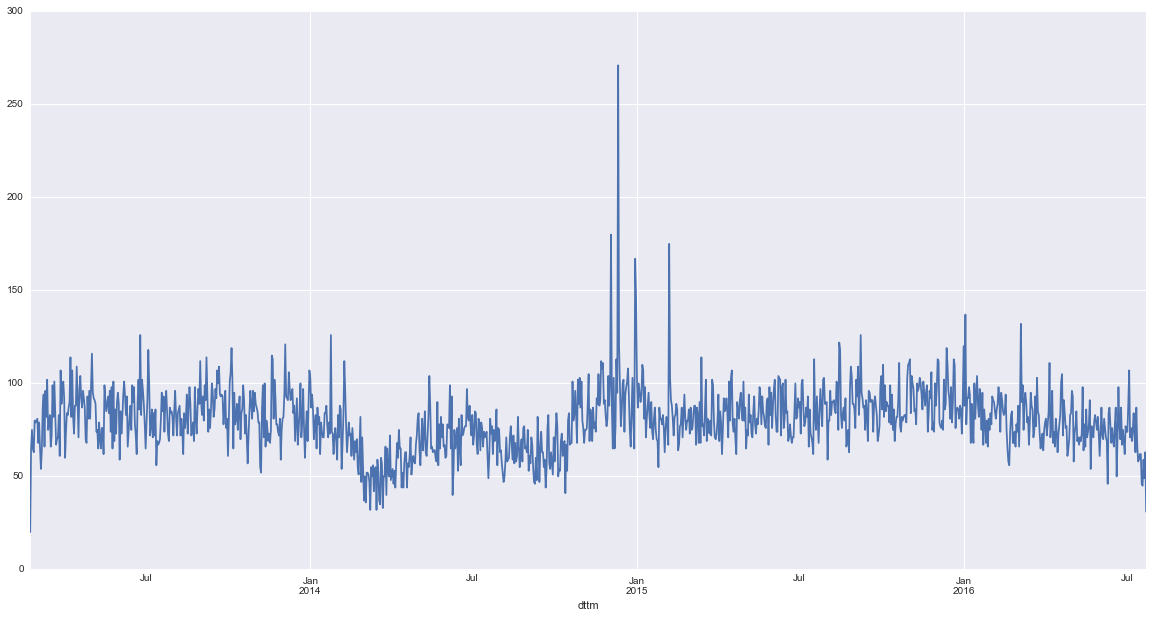

In [308]:
fdf.rename(columns={'alarm_dttm':'dttm'}).set_index('dttm').groupby(pd.TimeGrouper('D')).count()['incident_number'].plot(figsize=(20,10))

In the above chart, there is a HUGE spike and a number of smaller spikes during the month of December 2014. It turns out this spike occurred on December 11 2014. So we'll look into that more...

In [318]:
mintime = pd.tslib.Timestamp("December 11 2014")
maxtime = pd.tslib.Timestamp("December 12 2014")
mask = ((fdf.alarm_dttm >= mintime) & (fdf.alarm_dttm < maxtime)) 
fdf[mask].primary_situation.value_counts(dropna=False).head()

444 power line down                                     31
745 alarm system activation, no fire - unintentional    22
735 alarm system sounded due to malfunction             21
353 removal of victim(s) from stalled elevator          19
700 false alarm or false call, other                    17
Name: primary_situation, dtype: int64


Further exploration reveals that the biggest spike in early December 2014 was the cause of another big storm. You can read about it [here](http://www.nytimes.com/2014/12/12/us/california-storm-pineapple-express-san-francisco-braces.html?_r=0)

![pic of kids enjoying Dec 2014 flood](http://www.gannett-cdn.com/-mm-/7eb5ee01dc0b674cc6d0f0472270b998bc23b36b/c=252-0-3542-2474&r=x513&c=680x510/local/-/media/2014/12/11/DetroitNews/DetroitNews/635539103606182231-storms010.JPG)




### So far

I'm not seeing a strong correlation between raw number of incidents, and the ambient temperature. This could simply be because I need to look at low temperature separately from high temp, or do a better job of segmenting the data based on zipcode, etc. There's still work to be done to clean and munge that data to try and reject our null hypothesis.

First though, let's take a look at an aggregation by month.



In [309]:
ndf['month'] = ndf.dttm.apply(lambda x: x.month)

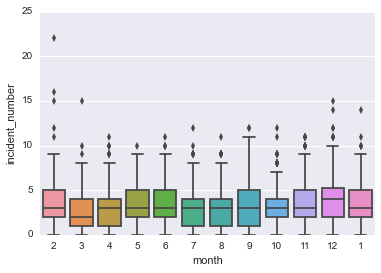

In [311]:
sns.boxplot(x='month', y='incident_number', data=ndf)


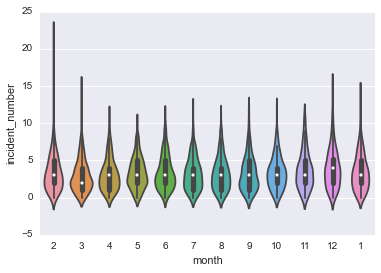

In [310]:
sns.violinplot(x='month', y='incident_number', data=ndf)


Based on the above box and violin plots, I find the outliers of December and February interesting, but also it's interesting how even the medians are across most months. The medians visually appear unchanged across all months, except for a higher value in December and a lower value in March. 

In [312]:
ndf['year'] = ndf.dttm.apply(lambda x: x.year)

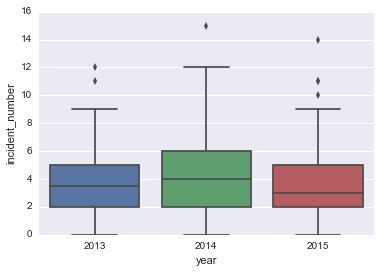

In [314]:
sns.boxplot(x='year', y='incident_number', data=ndf[ndf.month == 12])

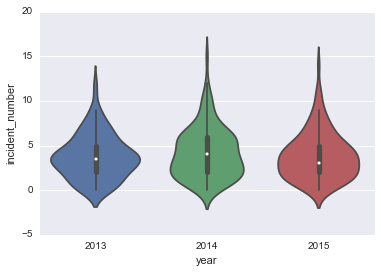

In [313]:
sns.violinplot(x='year', y='incident_number', data=ndf[ndf.month == 12])

Looking at the years, it seems 2014 was elevated in many ways, and the kde plots that shape the violin plot are interesting in how each year takes on a different distribution. Not sure yet what that means, but another item to circle back and explore, especially when we have more years to work with.

## Precipitation over Temp

So far it seems that the main cause of a large number of calls to the fire department is due to precipitation. It's long been a joke about how Californians don't know how to drive in the rain, particularly when there are long dry spells between storms. The roads accumulate oils and dust and debris, and the sudden downpour creates road surfaces that are both slick and also jagged. If the slick surface from both water and oil can cause a vehicle to spin out, as can a tire puncture caused from newly exposed debris. 

At least, theoretically, that's what we hear about driving in California in the winter. What we see so far, however, are massive storms of several inches flooding roads, and blowing down trees that knock out power. 

I found it interesting that on December 11 2014, the most common cause of calls were 43 incidents of an alarm system being activated due to malfunction, and that's not including 17 calls that were categorized as "false alarm or false call, other". 

The second most common call that day was related to down power lines, and the third most common was surprising to me: there were 19 incidents where the SFFD was contacted to remove victim(s) from stalled elevators. 

Originally I began exploring this data looking for ambient temperature as having a correlation with behavior changes, either as people began turning on heating systems in the winter, or becoming more social and careless with open flame in the summer. I do not see that happening (yet) with the fire data, but instead there seems to be a very large burden on the fire department when a large storm hits the SF Bay Area. So that's what we'll probe on next: what variable does the weather service provide that can be used as a predictor for an increased need for resources with the fire department?


In [288]:
# TODO NEXT: 
# since the goal of this analysis would be to predict the future number of calls, I'll have to get trickier and 
# do a moving average of timeshift
# but first, do a simple graph where tdf is simply PRECIPITATION


We will grab the noaa data again, but this time we will only filter on the precipitation data.

In [329]:
def get_noaa_prec_dataframe():
    df = pd.read_table('../../data/external/noaa/5991787088242dat.txt', delim_whitespace=True)

    # The building ferry data sucks. I'll look at the SF Airport dataa
    df = df[df.USAF == 724940]  # SFO data
    
    # YR--MODAHRMN = YEAR-MONTH-DAY-HOUR-MINUTE IN GREENWICH MEAN TIME (GMT)
    df['dttm'] = pd.to_datetime(df['YR--MODAHRMN'], format='%Y%m%d%H%M')
    cols_to_keep = [#'USAF', 
                    "PCP01",
                    "PCP06",
                    "PCP24",
                    'dttm']
    df = df[cols_to_keep]
    for col in df.columns:
        if 'PCP' in col:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [330]:
tdf = get_noaa_prec_dataframe()

In [331]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40505 entries, 0 to 40504
Data columns (total 4 columns):
PCP01    29820 non-null float64
PCP06    682 non-null float64
PCP24    1541 non-null float64
dttm     40505 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [332]:
tdf.describe()

,PCP01,PCP06,PCP24
count,29820.000000,682.000000,1541.000000
mean,0.002144,0.131026,0.089104
std,0.017236,0.201184,0.268171
min,0.000000,0.000000,0.000000
25%,0.000000,0.010000,0.000000
50%,0.000000,0.040000,0.000000
75%,0.000000,0.180000,0.030000
max,0.710000,1.300000,3.540000


Yikes! The number of actual values in this table is very sparse. At least `PCP01` has a sizeable amount, in the neighborhood of 30K non null data points. However I think it's worth `PCP06` 

ERROR! Session/line number was not unique in database. History logging moved to new session 1532


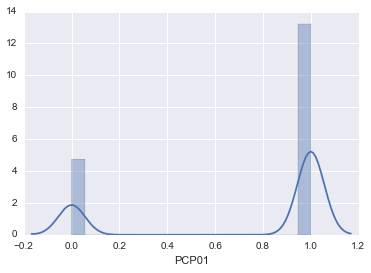

In [337]:
sns.distplot(tdf.PCP01.notnull())

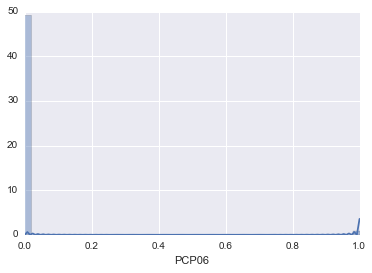

In [339]:
sns.distplot(tdf.PCP06.notnull())

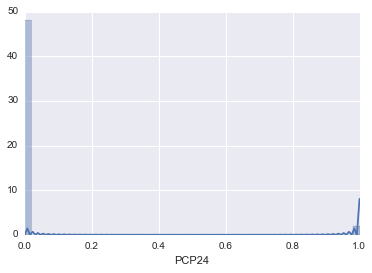

In [338]:
sns.distplot(tdf.PCP24.notnull())

### Outliers 

Because I'm a big fan of looking at statistical outliers to understand hidden trends in the data to probe on, we will use this definition of an outlier from [Wolfram Alpha](http://mathworld.wolfram.com/Outlier.html):

>A convenient definition of a outlier is a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile.

So let's quickly figure out what that number is for incident number, but also for temp.

In [320]:
def outlier_range(s):
    """
    Given a pandas Series, return the upper and lower boundaries
    for the outlier, which is 1.5 times the interquartile range above the third quartile
    or below the first quartile."""
    first_quartile = None
    third_quartile = None
    # TODO: FINISH THIS